# Symbolic derivation qubit-cavity Hamiltonian

<style>
p {
    font-family: "Liberation Serif", serif;
    font-size: 12pt;
}
</style>


Based on: J. R. Johansson (robert@riken.jp), [http://jrjohansson.github.io](http://jrjohansson.github.io), and Eunjong Kim.

## Setup modules

In [3]:
from sympy import *
init_printing()

In [4]:
from sympsi import *
from sympsi.boson import *
from sympsi.pauli import *

## The Jaynes-Cummings model

The [Jaynes-Cummings model](http://en.wikipedia.org/wiki/Jaynes%E2%80%93Cummings_model) is one of the most elementary quantum mechanical models light-matter interaction. It describes a single two-level atom that interacts with a single harmonic-oscillator mode of a electromagnetic cavity.

The Hamiltonian for a two-level system in its eigenbasis can be written as

$$
H = \frac{1}{2}\omega_q \sigma_z
$$

and the Hamiltonian of a quantum harmonic oscillator (cavity) is

$$
H = \hbar\omega_r (a^\dagger a + 1/2)
$$

The atom interacts with the electromagnetic field produced by the cavity mode $a + a^\dagger$ through its dipole moment. The dipole-transition operators is $\sigma_x$ (which cause a transition from the two dipole states of the atom). The combined atom-cavity Hamiltonian can therefore be written in the form

$$
H = 
\hbar\omega_r (a^\dagger a + 1/2)
+ \frac{1}{2}\hbar\Omega\sigma_z 
+
\hbar
g\sigma_x(a + a^\dagger)
$$




Although the Jaynes-Cumming Hamiltonian allow us to evolve the given initial state according to the Schrödinger Equation, in an experiment we would like to predicte the response of the coupled cavity-qubit system under the influence of driving fields for the cavity and qubit, and also account for the effects of dissipation and dephasing (not treated here)

The external coherent-state input may be incorporated in the Jaynes-Cummings Hamiltonian by addition of terms involving the amplitude of the driving field $\vec{E_d} \left(\vec{E_s}\right)$ and it's frequency $\omega_d\left(\omega_s\right)$

$$
H_{cavity} = 
E_d \left(e^{i\omega_dt}a +e^{-i\omega_dt}\right)
$$

$$
H_{qubit} = 
E_s \left(e^{i\omega_st}a +e^{-i\omega_st}\right)
$$

To obtain the Jaynes-Cumming Hamiltonian 

$$
H = 
\hbar\omega_r (a^\dagger a + 1/2)
%-\frac{1}{2}\Delta\sigma_x 
+ \frac{1}{2}\hbar\Omega\sigma_z 
+
\hbar
g(\sigma_+ a + \sigma_- a^\dagger)
$$

we also need to perform a rotating-wave approximation which simplifies the interaction part of the Hamiltonian. In the following we will begin with looking at how these two Hamiltonians are related.

To represent the atom-cavity Hamiltonian in SymPy we creates an instances of the operator classes `BosonOp` and `SigmaX`, `SigmaY`, and `SigmaZ`, and use these to construct the Hamiltonian (we work in units where $\hbar = 1$).

In [5]:
omega_r, omega_q, g, Delta_d, Delta_s, t, x, chi, Hsym = symbols("omega_r, omega_q, g, Delta_d, Delta_s, t, x, chi, H")
A, B = symbols("A,B") # Electric field amplitude
omega_d, omega_s = symbols("omega_d, omega_s")
Delta,Delta_t = symbols("Delta,Delta_t")

In [6]:
sx, sy, sz, sm, sp = SigmaX(), SigmaY(), SigmaZ(), SigmaMinus(), SigmaPlus()
a = BosonOp("a")

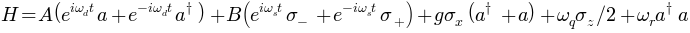

In [7]:
H = omega_r * Dagger(a) * a + omega_q/2 * sz 
H_int = g * sx * (a + Dagger(a))
H_drive_r = A * (exp(I*omega_d*t)*a + exp(-I*omega_d*t)*Dagger(a))
H_drive_q = B * (exp(I*omega_s*t)*sm + exp(-I*omega_s*t)*sp)
H_total =  H+ H_drive_r + H_drive_q+ H_int
Eq(Hsym, H+ H_drive_r + H_drive_q+ H_int)


Unitary transformation to interaction picture

In [8]:
U = exp(I  * omega_r * t * Dagger(a)*a)
U

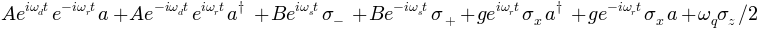

In [9]:
H1 = hamiltonian_transformation(U, H_total.expand())

H1

In [10]:
U = exp(I * omega_q * t * sp * sm)

U

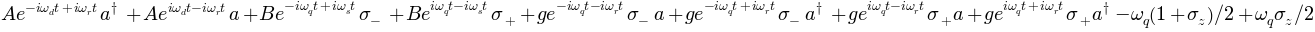

In [11]:
H2 = hamiltonian_transformation(U, H1.expand())

H2 = H2.subs(sx, sm + sp).expand()

H2 = powsimp(H2)

H2

In [12]:
# trick to simplify exponents
def simplify_exp(e):
    if isinstance(e, exp):
        return exp(simplify(e.exp.expand()))

    if isinstance(e, (Add, Mul)):
        return type(e)(*(simplify_exp(arg) for arg in e.args)) 

    return e

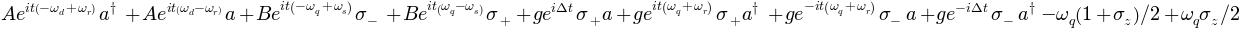

In [13]:
H3 = simplify_exp(H2).subs(-omega_r + omega_q, Delta)

H3

Now, in the rotating-wave approximation we can drop the fast oscillating terms containing the factors
$e^{\pm i(\omega_q + \omega_r)t}$

In [14]:
H4 = drop_terms_containing(H3, [exp( I * (omega_q + omega_r) * t),
                                exp(-I * (omega_q + omega_r) * t)])

H4 = drop_c_number_terms(H4.expand())

Eq(Hsym, H4)

This is the interaction term of in the Jaynes-Cumming model in the interaction picture. If we transform back to the Schrödinger picture we have:

In [ ]:
U = exp(-I * omega_r * t * Dagger(a) * a)
H5 = hamiltonian_transformation(U, H4.expand())
H5

In [ ]:
U = exp(-I * omega_q * t * sp * sm)
H6 = hamiltonian_transformation(U, H5.expand())
H6

In [ ]:
H7 = simplify_exp(H6).subs(Delta, omega_q - omega_r)
H7 = simplify_exp(powsimp(H7)).expand()

H7 = drop_c_number_terms(H7)

H = collect(H7, [A,B,g])

Eq(Hsym, H)

## Linearized interaction

First we apply the unitary transformation $U = e^{i \omega_d a^\dagger a t}$:

In [ ]:
U = exp(I * Dagger(a) * a * omega_d * t)

U

In [ ]:
H1 = hamiltonian_transformation(U, H, independent=True)

H1

We can now perform a rotating-wave approximation (RWA) by eliminating all terms that rotate with frequencies $2\omega_d$:

In [ ]:
H2 = drop_terms_containing(H1.expand(), [exp(-2*I*omega_d*t), exp(2*I*omega_d*t)])
H2 = H2.collect([A,B,Dagger(a)*a,g])
H2
# Eq(Symbol("H_{rwa}"), H2)

Introduce the detuning $\Delta_d = \omega_r - \omega_d$:

In [ ]:
H3 = H2.subs(-omega_d+omega_r, Delta_d).expand()

H3 = H3.collect([A,B,Dagger(a)*a,g])
H3

In [ ]:
H3 = H3.subs(sz,2*sp*sm).expand()
H3

In [ ]:
H3 = H3.collect([A,B,Dagger(a)*a,g])
H3

Second we apply the unitary transformation $U = e^{i \omega_s \sigma_+ \sigma_- t}$:

In [ ]:
U = exp(I * sp*sm* omega_s * t)

U

In [ ]:
H4 = hamiltonian_transformation(U, H3, independent=True)

H4 =H4.expand()
H4

Substitute $ \sigma_+\sigma_-=\dfrac{\sigma_z}{2}$

In [ ]:
H4 = H4.subs(omega_q*sp*sm,omega_q*sz/2)
H4

In [ ]:
H4 = H4.subs(-omega_s*sp*sm,-omega_s*sz/2)
H4

In [ ]:
H4 = H4.subs(sp*sm,sz/2).expand()

H4= H4.collect([A,B,Dagger(a)*a,g,sz])
H4

Introduce the detuning $\Delta_s = \omega_q - \omega_s$:

In [ ]:
H4 = H4.subs(omega_q/2-omega_s/2,Delta_s/2).expand()

H5 = H4.collect([A,B,Dagger(a)*a,g,sz])
H5

In [ ]:
H5 = H5.expand()
H5

In [ ]:
H6 = simplify_exp(powsimp(H5))
H6 = simplify_exp(H6).subs(omega_d - omega_s, Delta_t)

H = H6.collect([A,B,Dagger(a)*a,g,sz])

In [ ]:
Eq(Hsym, H)

This is the Jaynes-Cumming model give above, and we have now seen that it is obtained to the dipole interaction Hamiltonian through the rotating wave approximation.

## Dispersive regime

In the dispersive regime, where the two-level system is detuned from the cavity by much more than the interaction strength, $\Delta \gg g$, an effective Hamiltonian can be dervied which describes the Stark shift of the two-level system (which depends on the number of photons in the cavity) and the frequency shift of the cavity (which depend on the state of the two-level system).

This effective Hamiltonian, which is correct up to second order in the small paramter $g/\Delta$, is obtained by performing the unitary transformation

$$
U = e^{\frac{g}{\Delta}(a \sigma_- - a^\dagger \sigma_+)}
$$

In [ ]:
U = exp(x * (a * sp).expand())

U

In [ ]:
#H1 = unitary_transformation(U, H, allinone=True, expansion_search=False, N=3).expand()
#H1 = qsimplify(H1)
#H1

In [ ]:
H1 = hamiltonian_transformation(U, H, expansion_search=False, N=3).expand()

H1 = qsimplify(H1)

H1

In [ ]:
U = exp(-x * (Dagger(a) * sm).expand())

U

In [ ]:
H2 = hamiltonian_transformation(U, H1, expansion_search=False, N=3).expand()

H2 = qsimplify(H2)

H2

In [ ]:
H3 = drop_terms_containing(H2.expand(), [x**3, x**4])

H3

In [ ]:
H4 = H3.subs(x, g/Delta)

H4

In [ ]:
H5 = drop_c_number_terms(H4)
H6 = drop_terms_containing(H5.expand(), [exp(I*Delta_t*t), exp(-I*Delta_t*t)])
H6

In [ ]:
H7 = collect(H6, [Dagger(a) * a, sz])

H7

Now move to a frame co-rotating with the qubit and oscillator frequencies: 

In [ ]:
H7.expand()

In [ ]:
H8 = qsimplify(H7.expand())
H9 = collect(H8, [Dagger(a) * a, sz])
H9

In [ ]:
H10 = qsimplify(H9)

H10 = collect(H10, [Dagger(a) * a, sz, A, B, Delta_s, Delta_d])

H10

This is the Hamiltonian of the Jaynes-Cummings model in the the dispersive regime. It can be interpreted as the resonator having a qubit-state-dependent frequency shift, or alternatively that the qubit is feeling a resonator-photon-number dependent Stark-shift.